# Weather Data Analysis
#### Ben Wilson

In this exercise we will learn to use an API to pull in the data we want to analyze.

First step is to gather the information we need to make the API call

In [1]:
cities = {
    'Atlanta': '33.762909,-84.422675',
    'Boston': '42.331960,-71.020173',
    'Chicago': '41.837551,-87.681844',
    'Miami': '25.775163,-80.208615',
    'New York': '40.663619,-73.938589',
    'Philadelphia': '40.009376,-75.133346',
    'San Francisco': '37.727239,-123.032229',
    'Seattle': '47.620499,-122.350876'
}

api_key = '01fc899a5b932b0768623072891d5687'

cities['Atlanta']

'33.762909,-84.422675'

In [2]:
# now that we have our variables initialized, lets make our api call
import datetime
import requests

start_date = datetime.datetime.now() - datetime.timedelta(days=30)

url = 'https://api.forecast.io/forecast/' + api_key + \
    '/' + cities['Atlanta'] + ',' + start_date.strftime('%Y-%m-%dT%H:%M:%S')

r = requests.get(url)
# r.json()
"""
{
  u'currently': {
      u'apparentTemperature': 83.73,
      u'cloudCover': 0.11,
      u'dewPoint': 69.98,
      u'humidity': 0.71,
      u'icon': u'clear-night',
      u'precipIntensity': 0,
      u'precipProbability': 0,
      u'pressure': 1015.18,
      u'summary': u'Clear',
      u'temperature': 80.42,
      u'time': 1465783968,
      u'visibility': 10,
      u'windBearing': 274,
      u'windSpeed': 5.78
  },
...
"""

"\n{\n  u'currently': {\n      u'apparentTemperature': 83.73,\n      u'cloudCover': 0.11,\n      u'dewPoint': 69.98,\n      u'humidity': 0.71,\n      u'icon': u'clear-night',\n      u'precipIntensity': 0,\n      u'precipProbability': 0,\n      u'pressure': 1015.18,\n      u'summary': u'Clear',\n      u'temperature': 80.42,\n      u'time': 1465783968,\n      u'visibility': 10,\n      u'windBearing': 274,\n      u'windSpeed': 5.78\n  },\n...\n"

Let's try to clean it up some and loop over all the cities to pull it into a database

In [3]:
import requests
import sqlite3 as lite
import datetime

# initialize some key variables
api_key = '01fc899a5b932b0768623072891d5687'
url = 'https://api.forecast.io/forecast/' + api_key + '/'

cities = {
    'atlanta': '33.762909,-84.422675',
    'boston': '42.331960,-71.020173',
    'chicago': '41.837551,-87.681844',
    'miami': '25.775163,-80.208615',
    'new_york': '40.663619,-73.938589',
    'philadelphia': '40.009376,-75.133346',
    'san_francisco': '37.727239,-123.032229',
    'seattle': '47.620499,-122.350876'
}

end_date = datetime.datetime.now()
query_date = end_date - datetime.timedelta(days=30)

# connect to the database
con = lite.connect('weather.db')
cur = con.cursor()

In [4]:
# initialize our table
with con:
    cur.execute('CREATE TABLE daily_temp (day_of_reading INT, atlanta REAL, boston REAL, chicago REAL, miami REAL,' \
               'new_york REAL, philadelphia REAL, san_francisco REAL, seattle REAL)')

In [5]:
with con:
    while query_date < end_date:
        cur.execute("INSERT INTO daily_temp(day_of_reading) VALUES (?)", (int(query_date.strftime('%S')),))
        query_date += datetime.timedelta(days=1)

In [6]:
for k, v in cities.iteritems():
    query_date = end_date - datetime.timedelta(days=30) # reset our starting query date
    while query_date < end_date:
        r = requests.get(url + v + ',' + query_date.strftime('%Y-%m-%dT12:00:00')) # get info at noon
        
        with con:
            cur.execute('UPDATE daily_temp SET ' + k + ' = ' + str(r.json()['daily']['data'][0]['temperatureMax']) + ' WHERE day_of_reading = ' + query_date.strftime('%S'))
            
        query_date += datetime.timedelta(days=1)
        
con.close()

Now that we have the data loaded in from the API it's time to do some analysis

In [10]:
import pandas as pd
import sqlite3 as lite

con = lite.connect('weather.db')
cur = con.cursor()

df = pd.read_sql_query("SELECT * FROM daily_temp ORDER BY day_of_reading", con, index_col="day_of_reading")
df[:4]

,atlanta,boston,chicago,miami,new_york,philadelphia,san_francisco,seattle
day_of_reading,,,,,,,,
43,91.58,83.36,88.08,90.39,79.71,86.74,56.65,72.71
43,91.58,83.36,88.08,90.39,79.71,86.74,56.65,72.71
43,91.58,83.36,88.08,90.39,79.71,86.74,56.65,72.71
43,91.58,83.36,88.08,90.39,79.71,86.74,56.65,72.71


In [13]:
print "Average Temperatures over the last 30 days"
print "Atlanta: " + str(df['atlanta'].mean())
print "Boston: " + str(df['boston'].mean())
print "Chicago: " + str(df['chicago'].mean())
print "Miami: " + str(df['miami'].mean())
print "New York: " + str(df['new_york'].mean())
print "Philadelphia: " + str(df['philadelphia'].mean())
print "San Francisco: " + str(df['san_francisco'].mean())
print "Seattle: " + str(df['seattle'].mean())

Average Temperatures over the last 30 days
Atlanta: 91.58
Boston: 83.36
Chicago: 88.08
Miami: 90.39
New York: 79.71
Philadelphia: 86.74
San Francisco: 56.65
Seattle: 72.71


In [16]:
# what about variance
print "Atlanta: " + str(df['atlanta'].var())
print "Boston: " + str(df['boston'].var())
print "Chicago: " + str(df['chicago'].var())
print "Miami: " + str(df['miami'].var())
print "New York: " + str(df['new_york'].var())
print "Philadelphia: " + str(df['philadelphia'].var())
print "San Francisco: " + str(df['san_francisco'].var())
print "Seattle: " + str(df['seattle'].var())

Atlanta: 8.35648517531e-28
Boston: 2.08912129383e-28
Chicago: 8.35648517531e-28
Miami: 2.08912129383e-28
New York: 8.35648517531e-28
Philadelphia: 1.88020916444e-27
San Francisco: 4.70052291111e-28
Seattle: 8.35648517531e-28


Looks like Atlanta was the most extreme and Philadephia the most steady. Let's look at it on a histogram

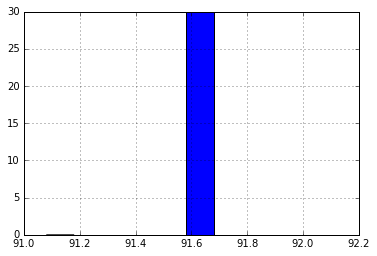

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

df['atlanta'].hist()
plt.show()

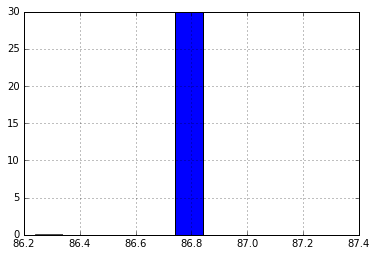

In [18]:
df['philadelphia'].hist()
plt.show()